# Importing the libraries and loading the data set

In [39]:
# Importing Libraries required.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.mixture import GaussianMixture

In [40]:
# Loading the data from the file.
data = pd.read_csv('mh.csv')

In [41]:
# Changing columns to a better format.
data.columns = [
    'is_self_employed',
    'number_of_employees',
    'is_tech_company',
    'is_role_tech_related',
    'provides_mental_health_benefits',
    'aware_of_mental_health_options',
    'employer_discusses_mental_health',
    'employer_resources_for_mental_health',
    'anonymity_protected_for_treatment',
    'request_medical_leave_due_to_mental_health',
    'fear_negative_consequences_discussing_mental_health',
    'fear_negative_consequences_discussing_physical_health',
    'comfortable_discussing_mental_health_with_coworkers',
    'comfortable_discussing_mental_health_with_supervisors',
    'employer_takes_mental_health_seriously',
    'observed_negative_consequences_for_open_discussions',
    'has_medical_coverage_for_mental_health',
    'aware_of_local_or_online_mental_health_resources',
    'disclosed_mental_health_issue_to_clients',
    'disclosure_impact_on_relationships_with_clients',
    'disclosed_mental_health_issue_to_coworkers',
    'disclosure_impact_on_relationships_with_coworkers',
    'productivity_impacted_by_mental_health',
    'percentage_of_work_time_impacted_by_mental_health',
    'has_previous_employers',
    'previous_employers_provided_mental_health_benefits',
    'aware_of_mental_health_options_with_previous_employers',
    'previous_employers_discussed_mental_health',
    'previous_employers_resources_for_mental_health',
    'anonymity_protected_for_previous_employers',
    'fear_negative_consequences_discussing_mental_health_previous',
    'fear_negative_consequences_discussing_physical_health_previous',
    'willing_to_discuss_mental_health_with_previous_coworkers',
    'willing_to_discuss_mental_health_with_previous_supervisors',
    'previous_employers_took_mental_health_seriously',
    'observed_negative_consequences_for_coworkers_previous',
    'willing_to_discuss_physical_health_in_interview',
    'reason_for_willingness_to_discuss_physical_health',
    'willing_to_discuss_mental_health_in_interview',
    'reason_for_willingness_to_discuss_mental_health',
    'fear_career_impact_from_mental_health_disclosure',
    'fear_negative_view_from_coworkers_due_to_mental_health',
    'willing_to_share_mental_health_with_friends_family',
    'observed_unsupportive_response_to_mental_health_issues',
    'impact_of_observing_others_on_disclosure_of_mental_health',
    'family_history_of_mental_illness',
    'history_of_mental_health_disorder',
    'current_mental_health_disorder',
    'diagnosed_conditions',
    'suspected_conditions',
    'diagnosed_by_professional',
    'diagnosed_conditions_by_professional',
    'sought_treatment_for_mental_health',
    'treatment_interference_with_work_when_effectively_treated',
    'treatment_interference_with_work_when_not_effectively_treated',
    'age',
    'gender',
    'country_of_residence',
    'us_state_or_territory_of_residence',
    'country_of_work',
    'us_state_or_territory_of_work',
    'work_position',
    'works_remotely'
]

# Ceaning

In [42]:
# Droping columns due to duplicate and defined in other columns or not enough  
print("Before:\n",data.shape)

columns_to_drop = [
    "country_of_work",
    "reason_for_willingness_to_discuss_mental_health",
    "reason_for_willingness_to_discuss_physical_health",
    #"sought_treatment_for_mental_health",
    #"fear_career_impact_from_mental_health_disclosure",
    ]
data.drop(columns_to_drop, axis=1, inplace=True)

print("\nAfter:\n",data.shape)

Before:
 (1433, 63)

After:
 (1433, 60)


In [43]:
# Removing uncertain answers and columns that are missing more than 30%, 29%, 24%, 22%, 21% or 20% of the values.
print("Before:\n",data.shape)

data = data.replace("Not applicable to me",np.nan)
data = data.replace("I don't know",np.nan)

percentage_missing = data.isnull().sum() * 100 / len(data)
col_to_drop = percentage_missing[percentage_missing > 30].keys()
data.drop(col_to_drop, axis=1, inplace=True)

print("\nAfter:\n",data.shape)

Before:
 (1433, 60)

After:
 (1433, 34)


In [44]:
# Cleaning ['age']. Transforming values to 4 categories.
#rint("Before:\n",data["age"].value_counts())

data['age'] = pd.cut(data['age'], bins=[18, 30, 40, 50, 60], 
                     labels=['18 to 30', '30 to 40', '40 to 50', '50+'], 
                     right=False).fillna('50+')

data['age'] = data['age'].astype('object')

In [45]:
# Cleaning ['gender']. Transforming values to 3 categories.
print("Before:\n",data["gender"].value_counts())

data["gender"] = data["gender"].str.lower()
data["gender"] = data["gender"].str.strip()

man = ["male","m","malr","sex is male","mail" , "dude","m|",
        "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?",
        "male.", "man"]
woman = ["f","woman", "female", "fm", " female", "female/woman",
         "female (props for making this a freeform field, though)",
         "fem", "female ", "i identify as female."]

data["gender"] = data["gender"].replace(man, "man")
data["gender"] = data["gender"].replace(woman, "woman")
data["gender"] = data["gender"].apply(lambda x: "diverse" if x not in ["man", "woman"] else x)

print("\nAfter:\n",data["gender"].value_counts())

Before:
 gender
Male           610
male           249
Female         153
female          95
M               86
              ... 
cis male         1
Human            1
Genderfluid      1
Enby             1
MALE             1
Name: count, Length: 70, dtype: int64

After:
 gender
man        1050
woman       334
diverse      49
Name: count, dtype: int64


In [46]:
# Cleaning ['work_position']. Transforming values to 3 categories.
print("Before:\n",data["work_position"].value_counts())

category_map = {
    "Management":["supervisor", "team lead", "leadership", "executive"],
    "Development":["back", "developer", "front", "devops", "sysadmin", "dev"],
}

def categorize_role(role):
    role = role.lower()
    for key, values in category_map.items():
        if any(value in role for value in values):
            return key
    return "Other"

data['work_position'] = data['work_position'].apply(categorize_role)

print("\nAfter:\n",data["work_position"].value_counts())

Before:
 work_position
Back-end Developer                                                                                              263
Front-end Developer                                                                                             125
Other                                                                                                           112
Supervisor/Team Lead                                                                                             68
Back-end Developer|Front-end Developer                                                                           61
                                                                                                               ... 
Front-end Developer|Back-end Developer|Support|Dev Evangelist/Advocate                                            1
Front-end Developer|Back-end Developer|Support|DevOps/SysAdmin|Dev Evangelist/Advocate                            1
Other|Dev Evangelist/Advocate|DevOps/SysAdmin|Sup

In [47]:
# Cleaning ['country_of_residence']. Reducing the number of countries and re labeling them as other if they are less than 3% of entire data.
print("Before:\n",data["country_of_residence"].value_counts())

value_counts = data['country_of_residence'].value_counts()
threshold = round(data.shape[0] * 0.04)
countries_to_keep = value_counts[value_counts >= threshold].index.tolist()
data['country_of_residence'] = data['country_of_residence'].apply(lambda x: x if x in countries_to_keep else "other")

print("\nAfter:\n",data["country_of_residence"].value_counts())

Before:
 country_of_residence
United States of America    840
United Kingdom              180
Canada                       78
Germany                      58
Netherlands                  48
Australia                    35
Sweden                       19
France                       16
Ireland                      15
Switzerland                  10
Brazil                       10
New Zealand                   9
India                         9
Russia                        9
Bulgaria                      7
Finland                       7
Denmark                       7
Italy                         5
Belgium                       5
South Africa                  4
Romania                       4
Spain                         4
Poland                        4
Austria                       4
Norway                        3
Pakistan                      3
Chile                         3
Czech Republic                3
Japan                         2
Israel                        2
Other     

In [48]:
# Cleaning and maping valeus of multiple columns to reduce the categories or value counts and for better readability.
replacements = {
    'country_of_residence': {
        "United States of America": "USA", 
        "United Kingdom": "UK"
    },
    'willing_to_share_mental_health_with_friends_family': {
        'Very open': 'Yes',
        'Somewhat open': 'MAybe',
        'Neutral': 'Maybe',
        'Somewhat not open': 'Maybe',
        'Not open at all': 'No',
        'Not applicable to me (I do not have a mental illness)': 'No'
    },
}

for column, mapping in replacements.items():
    data[column] = data[column].replace(mapping)

In [49]:
# Cleaning the data from missing values, while replacing them with the most frequent value.
for column in list(data.describe(exclude='object')):
    data.replace({column: {0: 'No', 1: 'Yes'}}, inplace=True)

print("Before:\n",data.describe())

data = data.replace("I am not sure",np.nan)
data = data.replace("N/A (not currently aware)",np.nan)

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(data)
imputed_data = mode_imputer.transform(data)
data = pd.DataFrame(data=imputed_data, columns=data.columns)

print("\nAfter:\n",data.describe())

Before:
        is_self_employed number_of_employees is_tech_company  \
count              1433                1146            1146   
unique                2                   6               2   
top                  No              26-100             Yes   
freq               1146                 292             883   

       aware_of_mental_health_options employer_discusses_mental_health  \
count                            1013                             1043   
unique                              3                                2   
top                                No                               No   
freq                              354                              813   

       fear_negative_consequences_discussing_mental_health  \
count                                                1146    
unique                                                  3    
top                                                 Maybe    
freq                                                  48

In [50]:
# Save the data as a CSV file called "Altered_MH.csv"
data.to_csv('Altered_MH.csv', index=False)

# Dimension reduction


In [51]:
# Encoding the values and scaling the data and reducing the dimensionality of the data using PCA.
label_encoder = LabelEncoder()

data_dim = data.copy()

for col in data_dim.select_dtypes(include='object').columns:
    data_dim[col] = label_encoder.fit_transform(data_dim[col])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_dim)

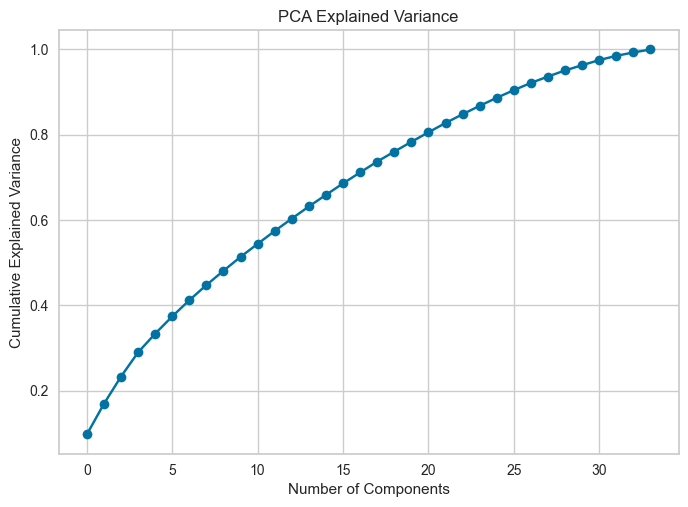

Using 21 components, which explains 80.57% of the variance.


In [52]:
# Step 1: PCA with a custom number of components based on the explained variance plot
pca = PCA().fit(data_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

# Choose number of components based on explained variance threshold (e.g., around the "elbow")
n_components = np.argmax(explained_variance >= 0.8) + 1  # Adjust threshold as needed
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

print(f"Using {n_components} components, which explains {explained_variance[n_components-1]*100:.2f}% of the variance.")

# Cluster

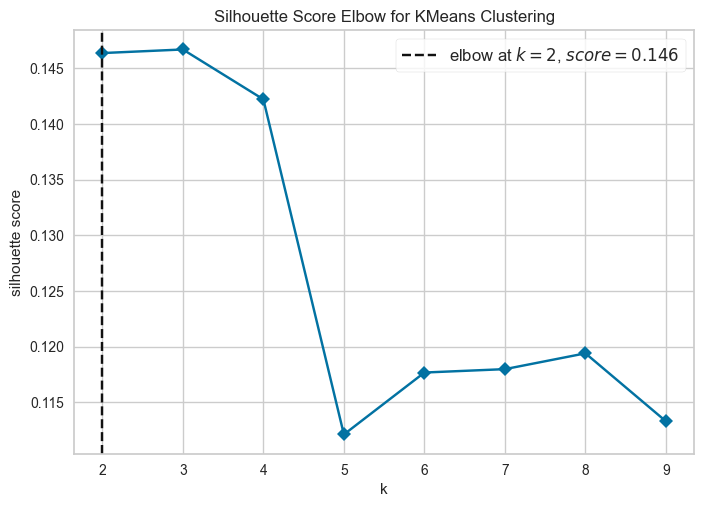

Optimal number of clusters:  2


In [ ]:
# Finding the best value for kmeans clusters with the help of Elbow method and Silhouette analysis.
model = KMeans(init="k-means++", max_iter=300)

elbow_visualizer = KElbowVisualizer(model, k=(3,10), metric='silhouette', timings=False)
elbow_visualizer.fit(data_pca)
elbow_visualizer.show()

print("Optimal number of clusters: ",elbow_visualizer.elbow_value_)

# Fiting KMeans based on optimal clusters.
optimal_clusters = elbow_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=1)
cluster_labels = kmeans.fit_predict(data_pca)

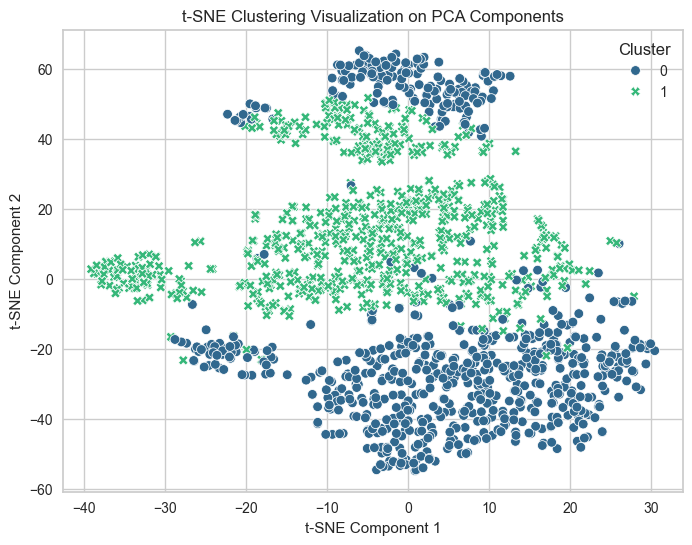

In [35]:
# Step 2: Use t-SNE for Visualization on reduced PCA components
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_pca)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=cluster_labels, palette='viridis', style=cluster_labels)
plt.title('t-SNE Clustering Visualization on PCA Components')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels = gmm.fit_predict(data_pca)

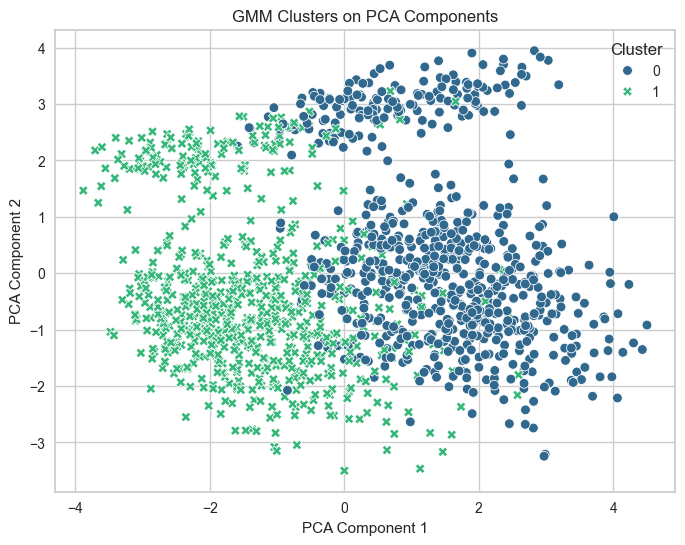

In [36]:
# Visualize GMM clusters on PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=gmm_labels, palette='viridis', style=gmm_labels)
plt.title('GMM Clusters on PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [37]:
# Visualising cluster quality metrics.
print("Inertia:", kmeans.inertia_)
print()
print("Silhouette Score:", silhouette_score(data_pca, cluster_labels))
print("Calinski-Harabasz Score:", calinski_harabasz_score(data_pca, cluster_labels))
print("Davies-Bouldin Score:", davies_bouldin_score(data_pca, cluster_labels))
print()
print("Silhouette Score (GMM):", silhouette_score(data_pca, gmm_labels))
print("Calinski-Harabasz Score (GMM):", calinski_harabasz_score(data_pca, gmm_labels))
print("Davies-Bouldin Score (GMM):", davies_bouldin_score(data_pca, gmm_labels))
print()
print("Silhouette Score (GMM):", silhouette_score(data_pca, gmm_labels) - silhouette_score(data_pca, cluster_labels))
print("Calinski-Harabasz Score (GMM):", calinski_harabasz_score(data_pca, gmm_labels) - calinski_harabasz_score(data_pca, cluster_labels))
print("Davies-Bouldin Score (GMM):", davies_bouldin_score(data_pca, gmm_labels) - davies_bouldin_score(data_pca, cluster_labels))

Inertia: 21326.706436304703

Silhouette Score: 0.14637088094492393
Calinski-Harabasz Score: 247.95447694768998
Davies-Bouldin Score: 2.3298783519968524

Silhouette Score (GMM): 0.14429408749933345
Calinski-Harabasz Score (GMM): 241.6628841780609
Davies-Bouldin Score (GMM): 2.3627702726944233

Silhouette Score (GMM): -0.0020767934455904746
Calinski-Harabasz Score (GMM): -6.291592769629091
Davies-Bouldin Score (GMM): 0.03289192069757085


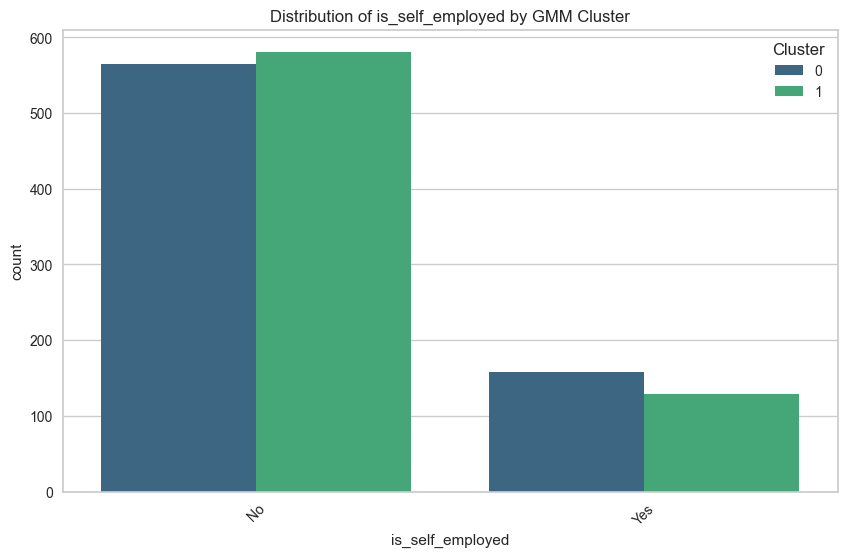

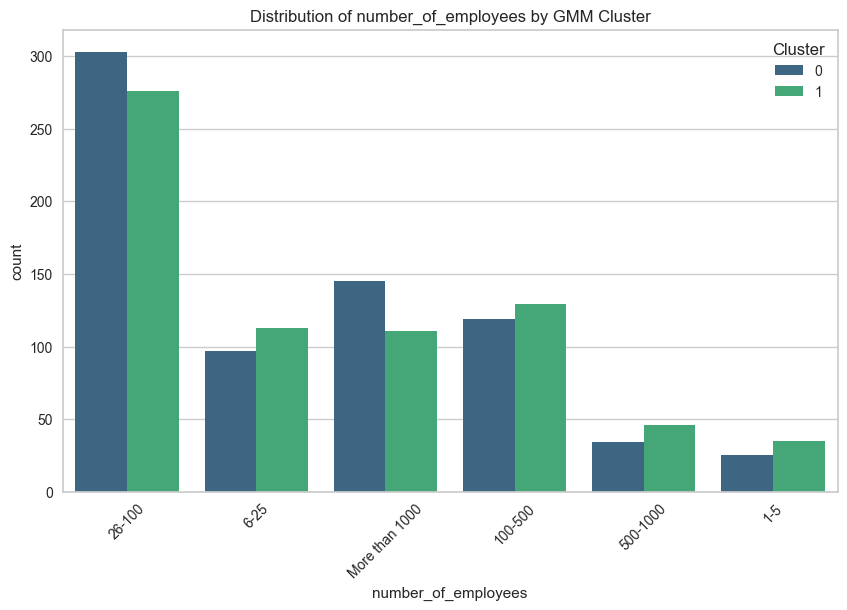

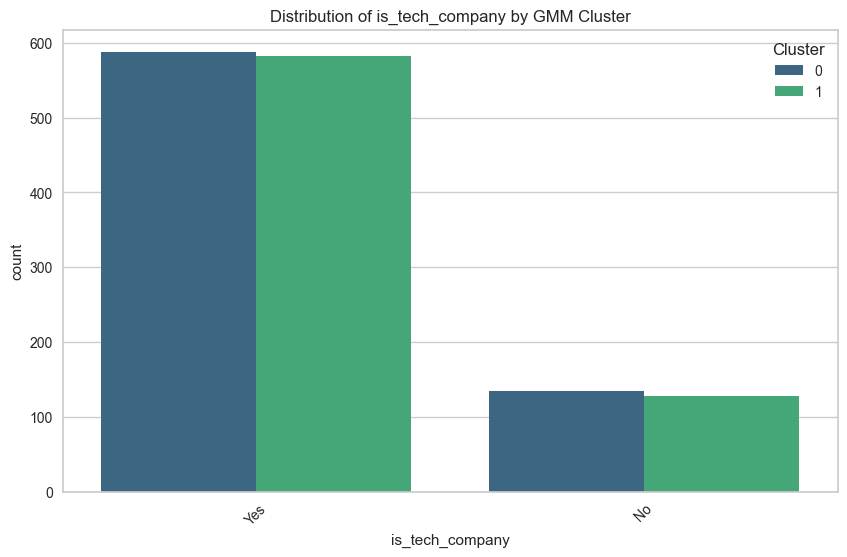

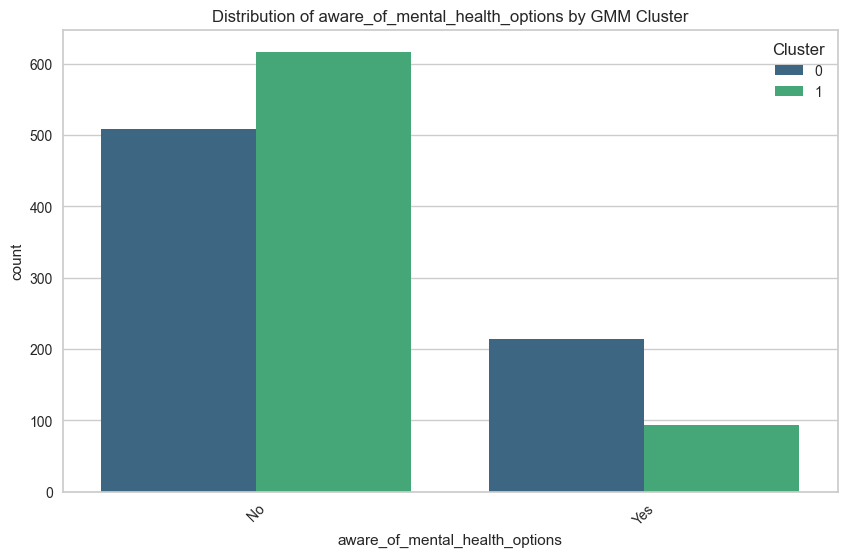

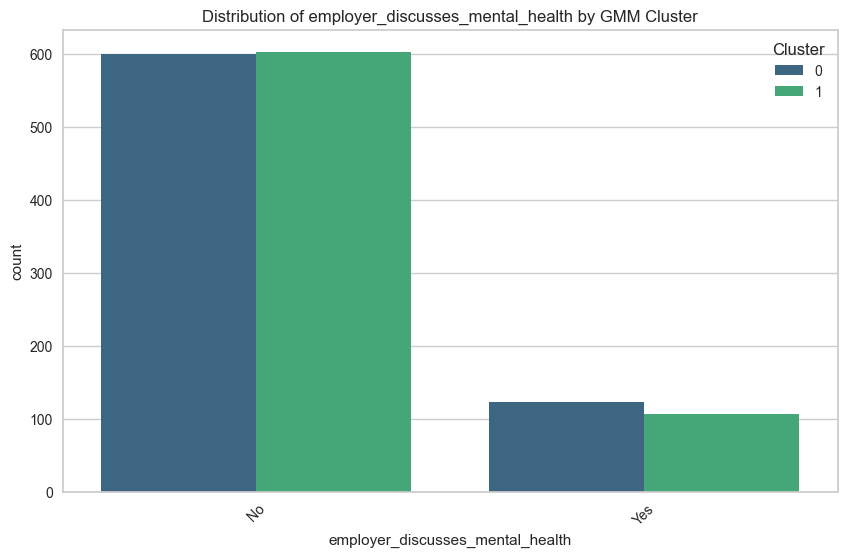

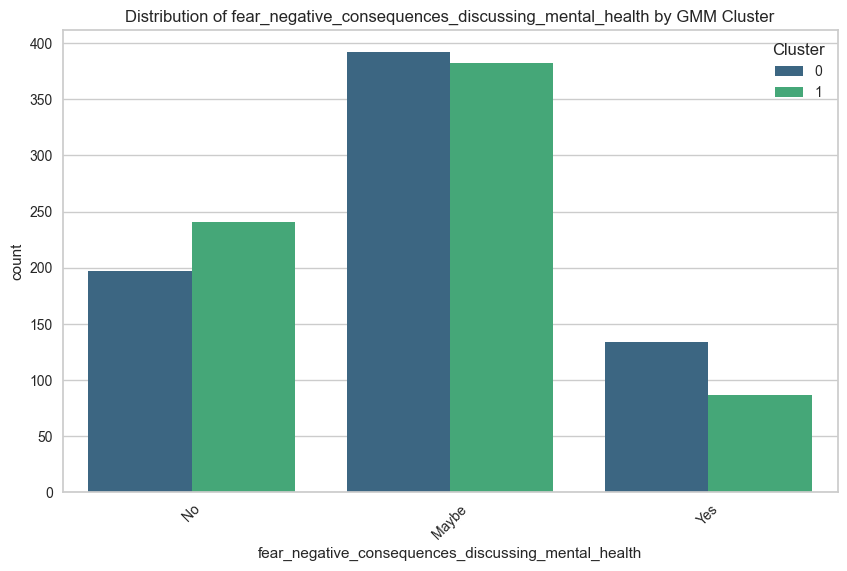

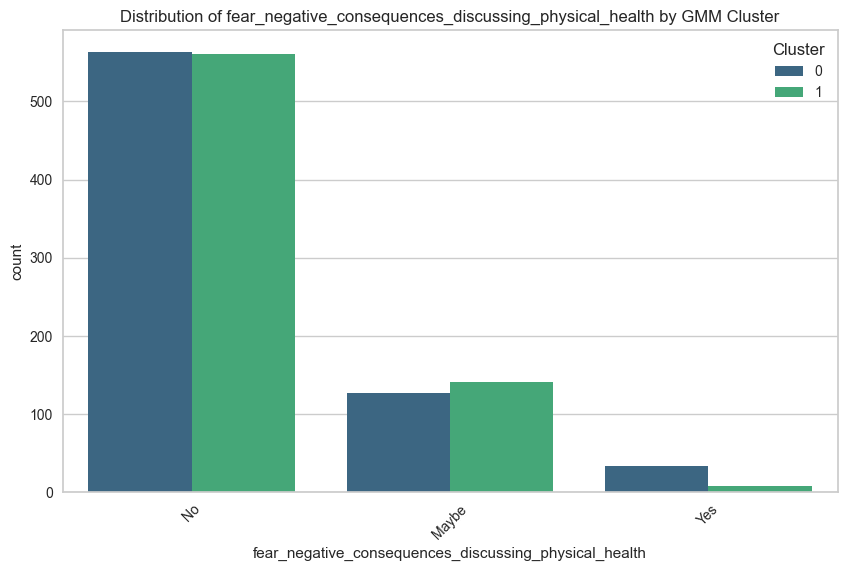

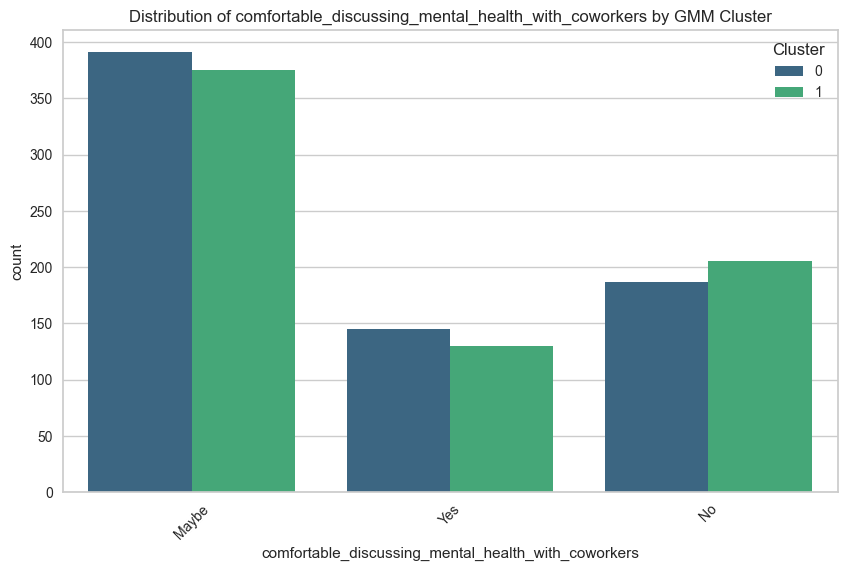

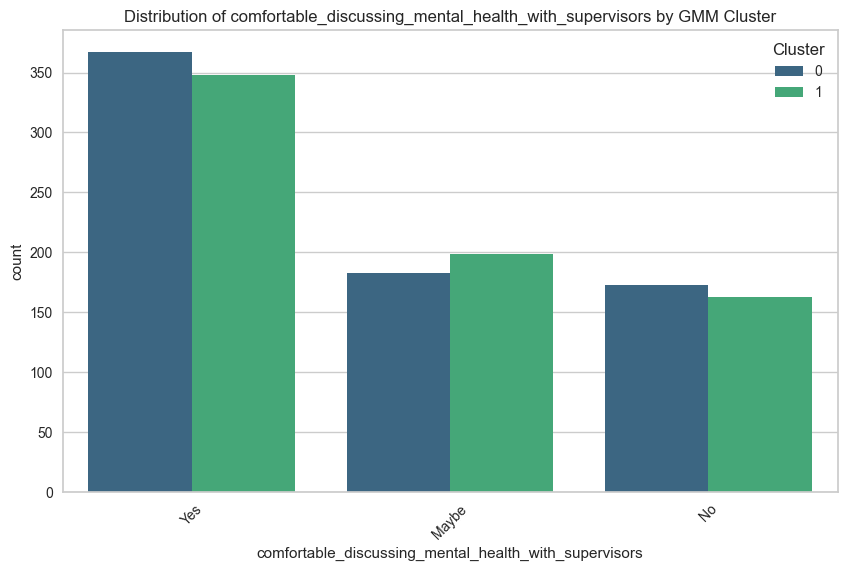

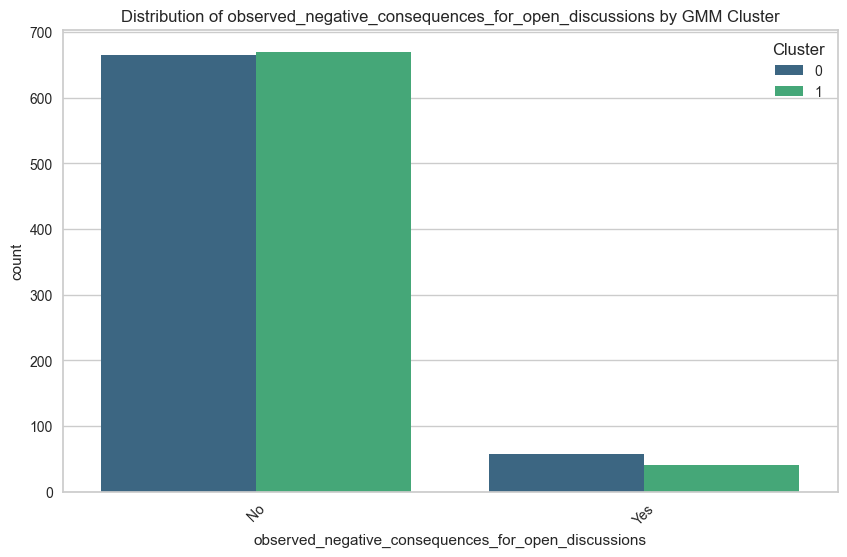

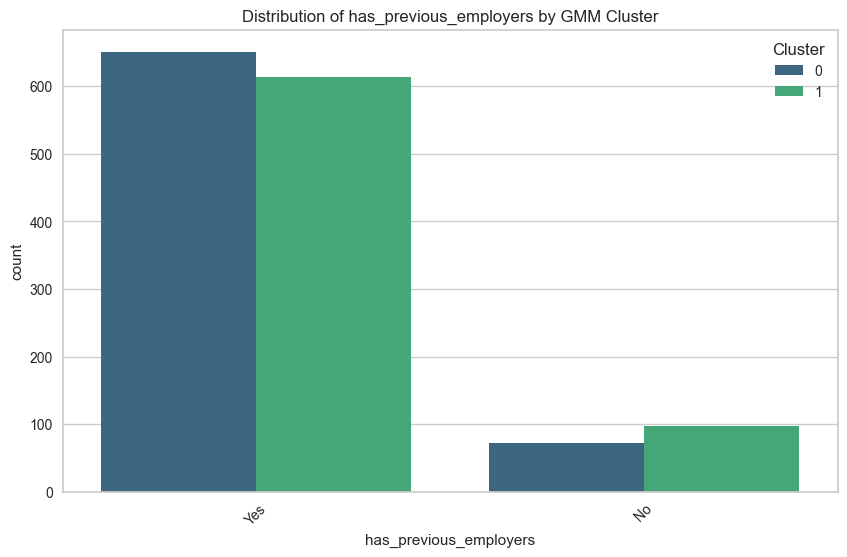

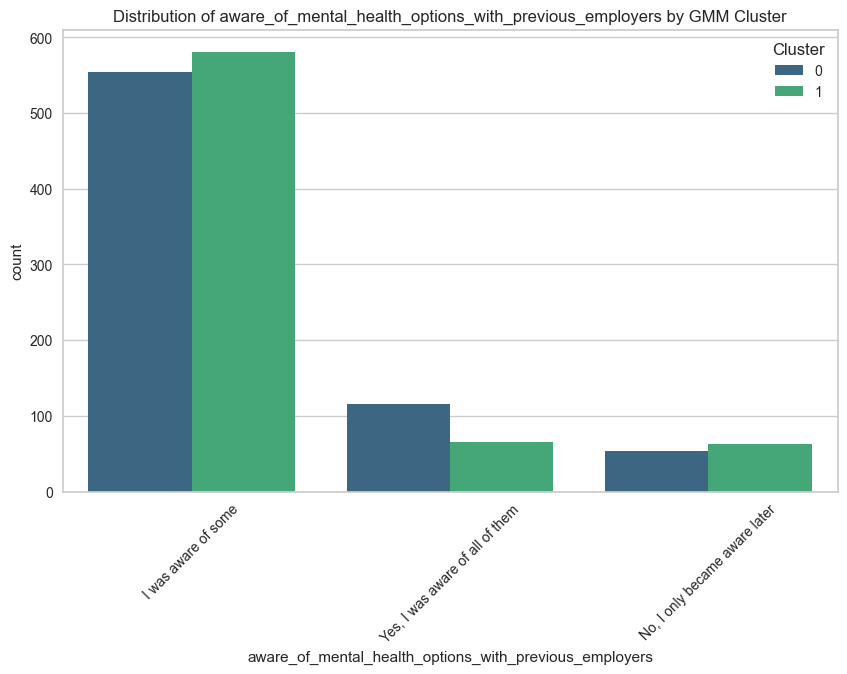

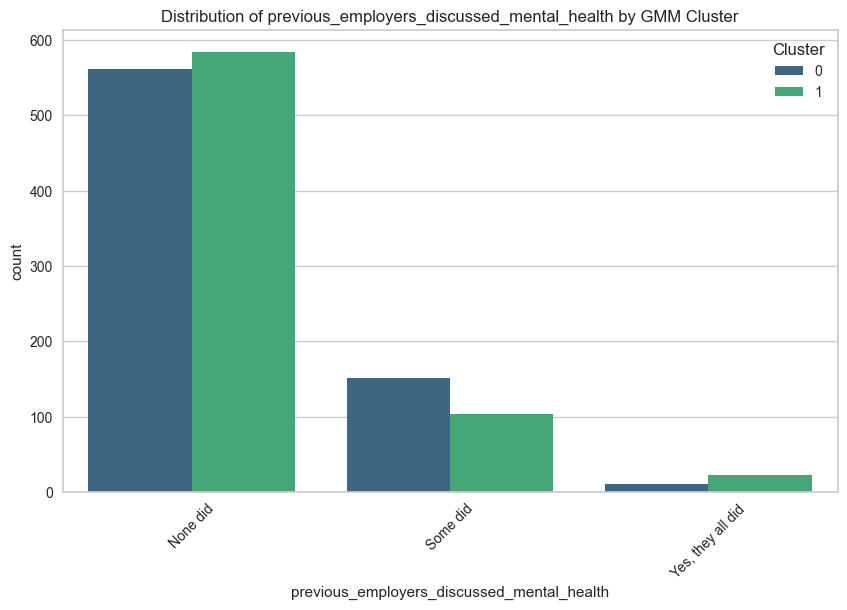

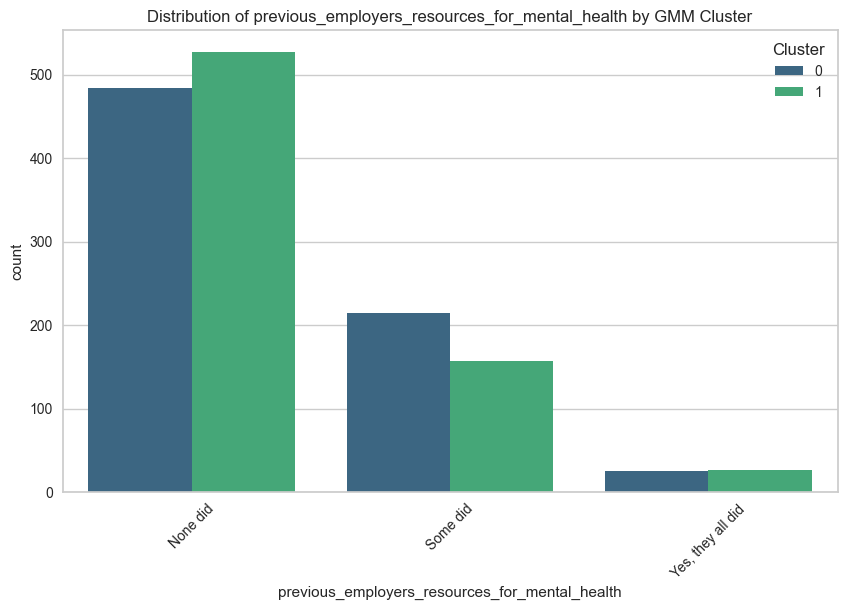

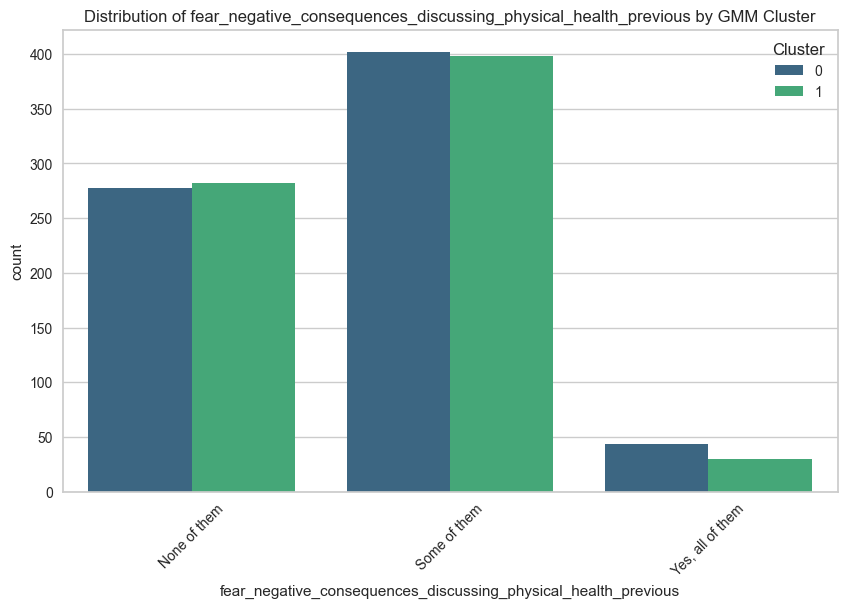

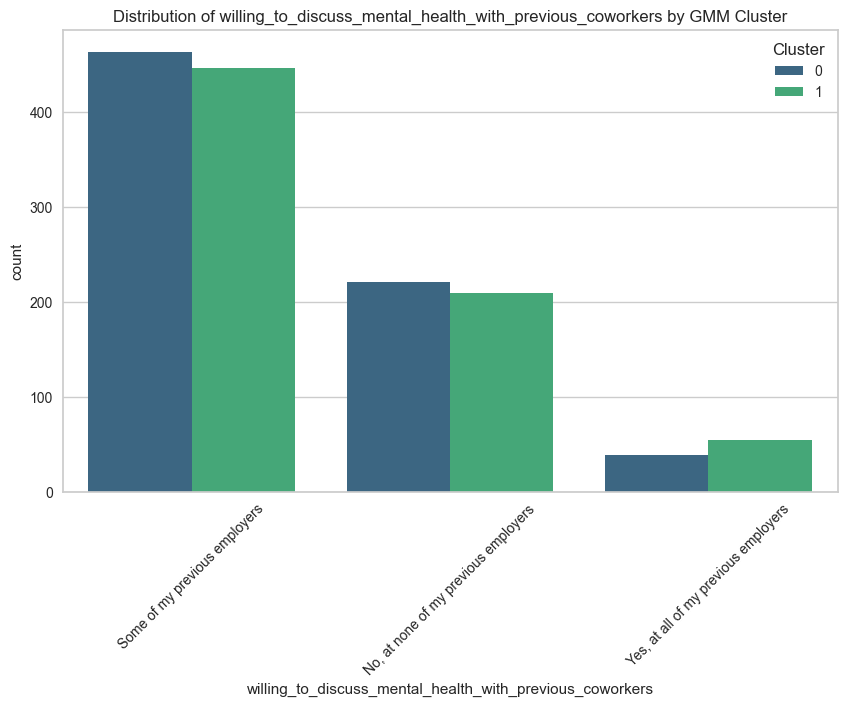

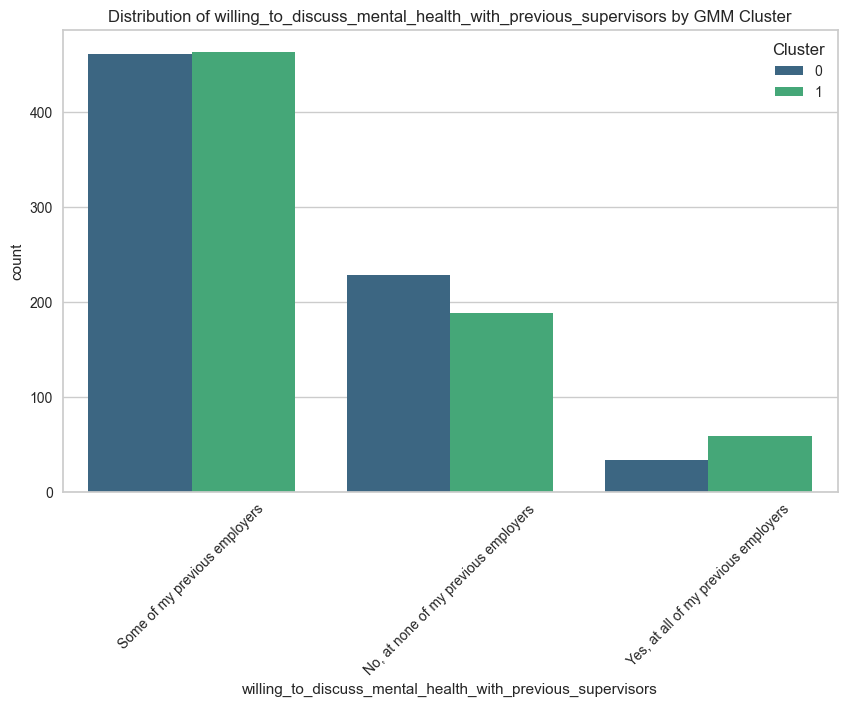

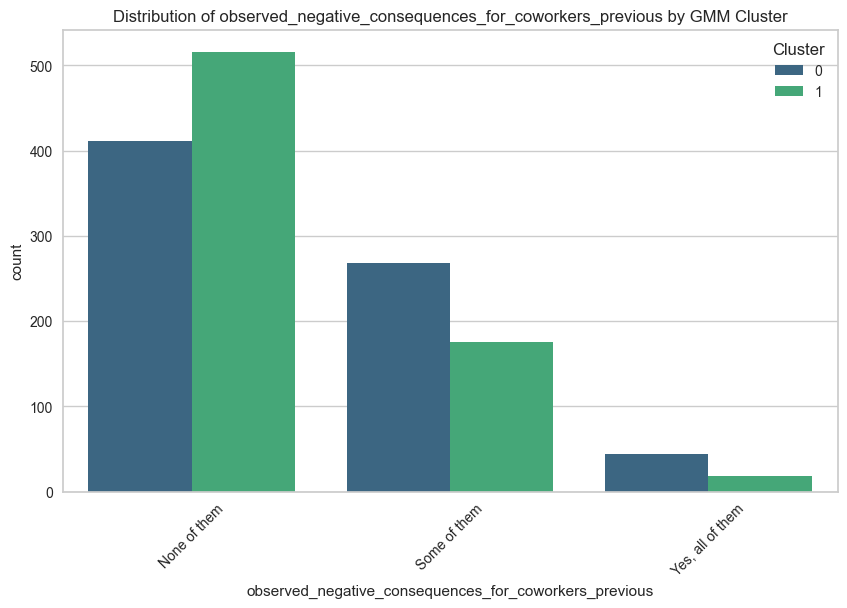

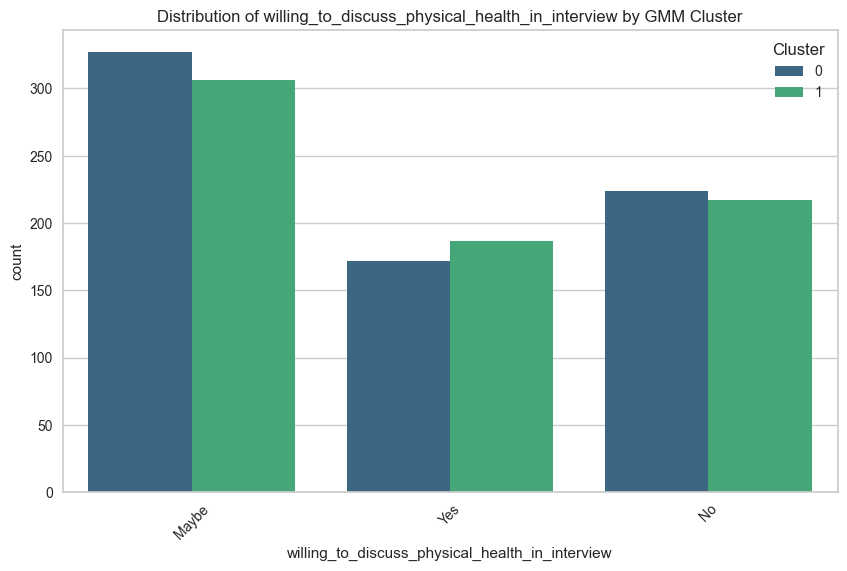

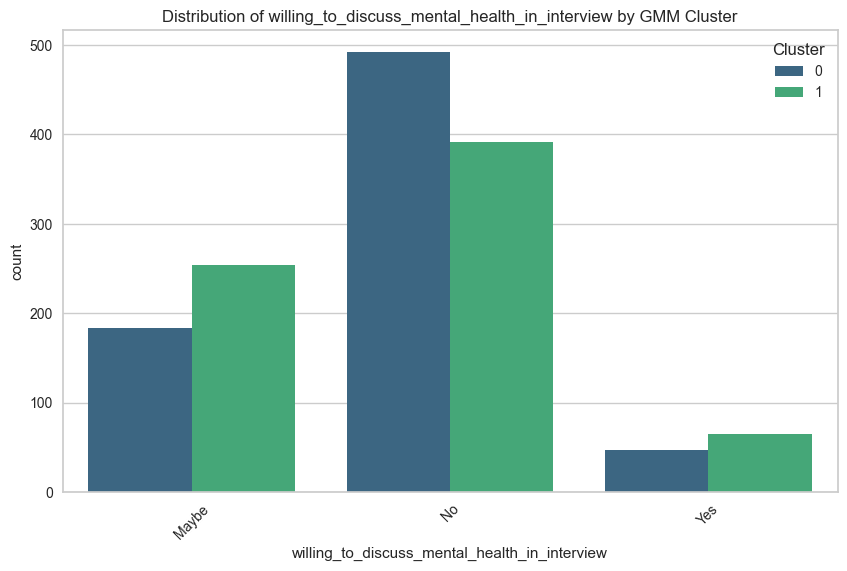

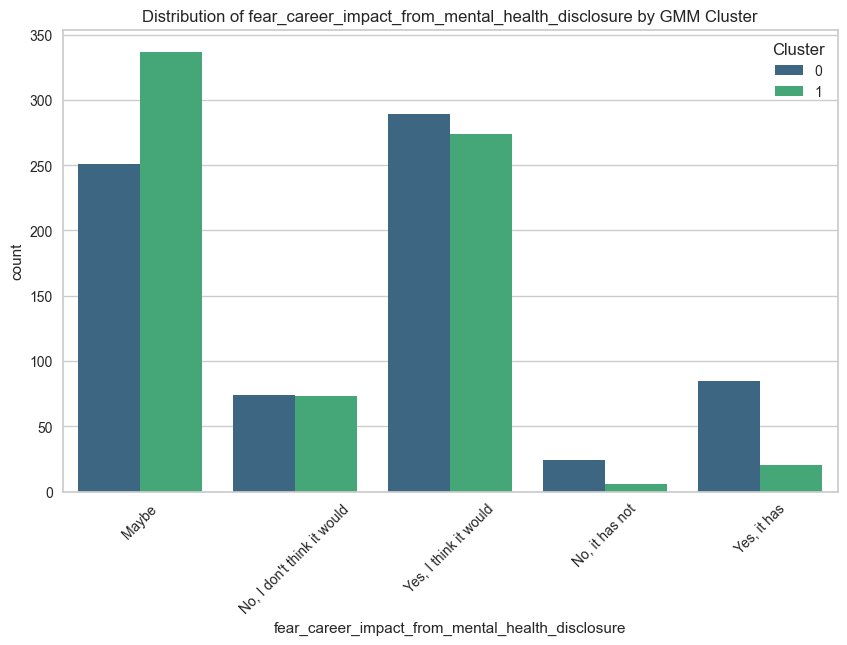

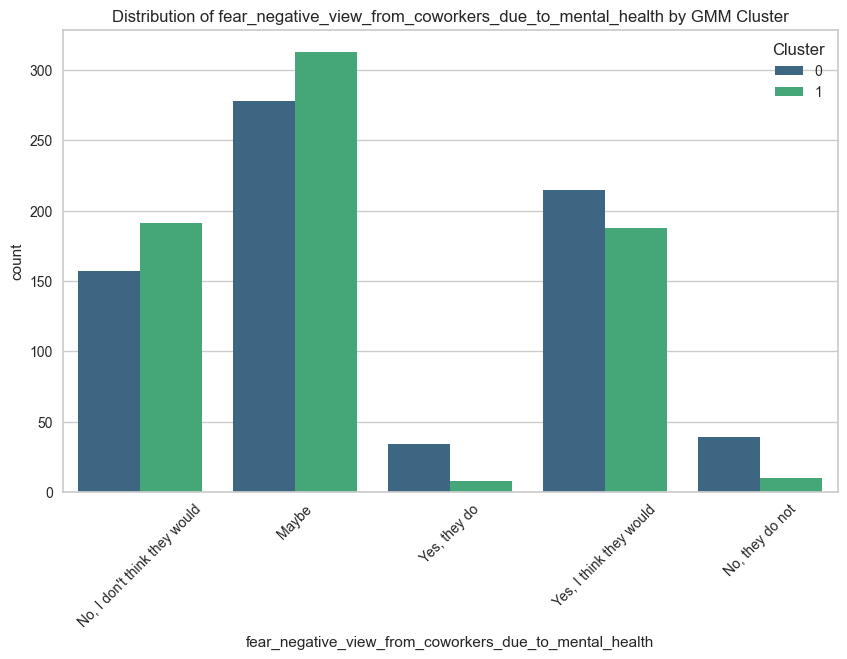

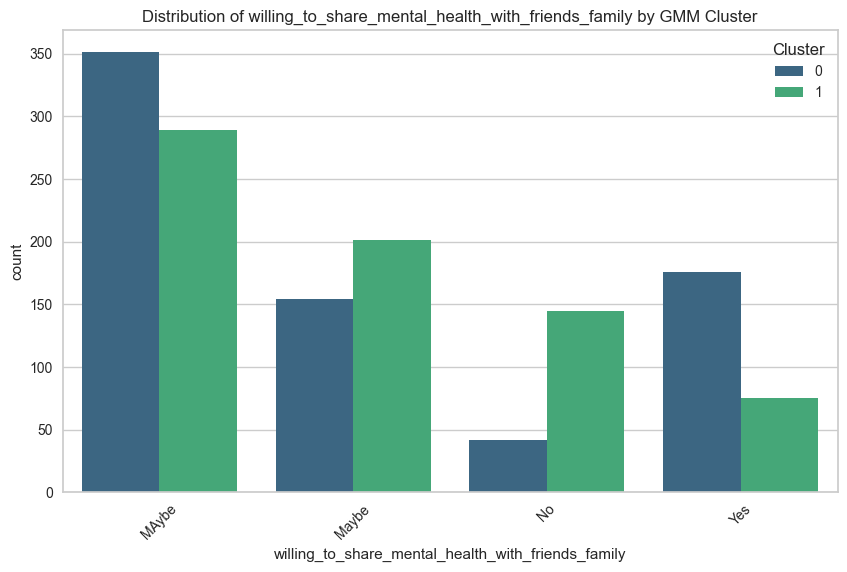

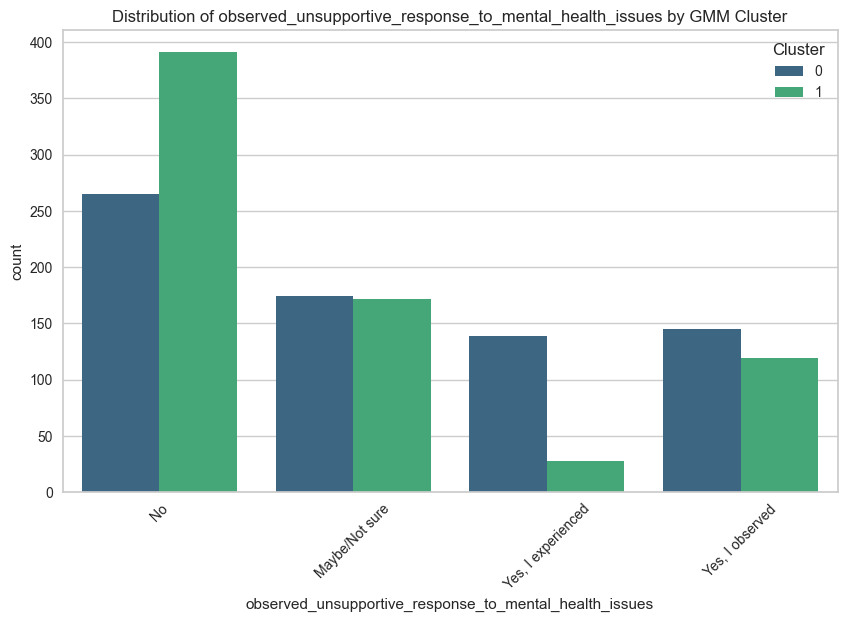

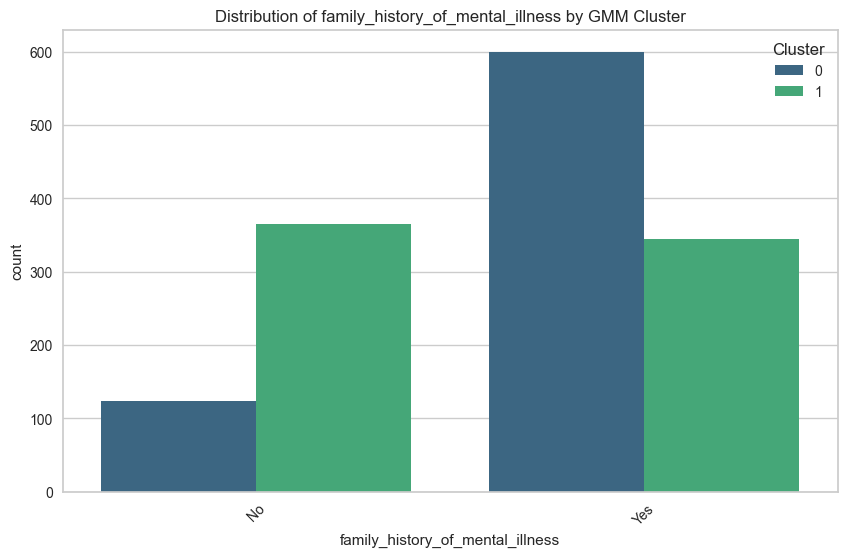

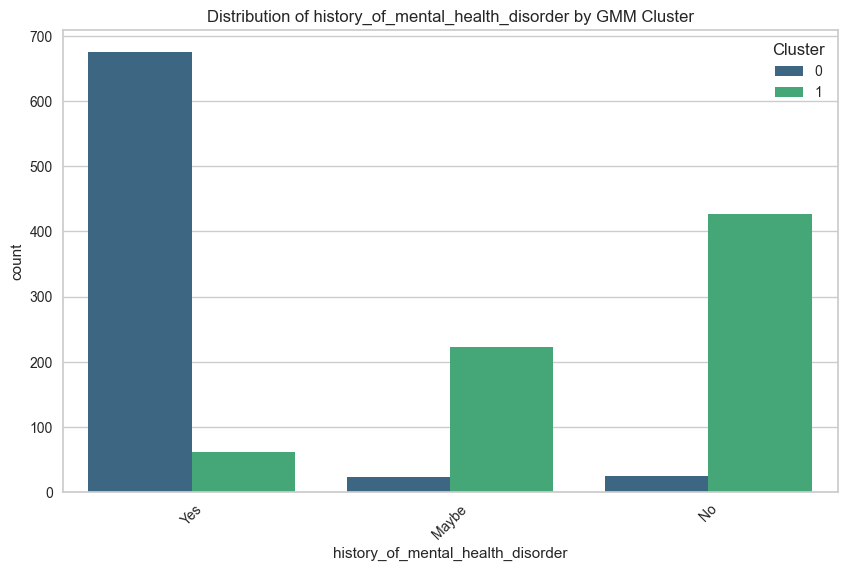

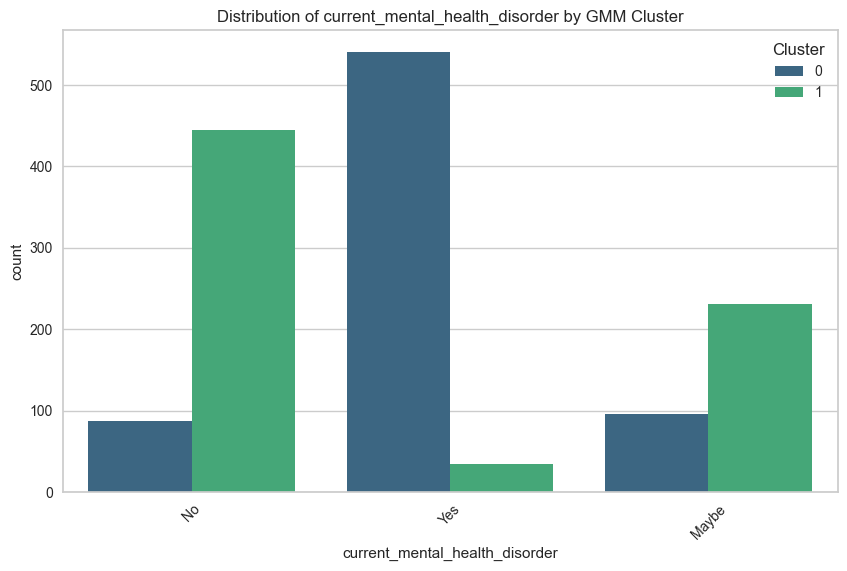

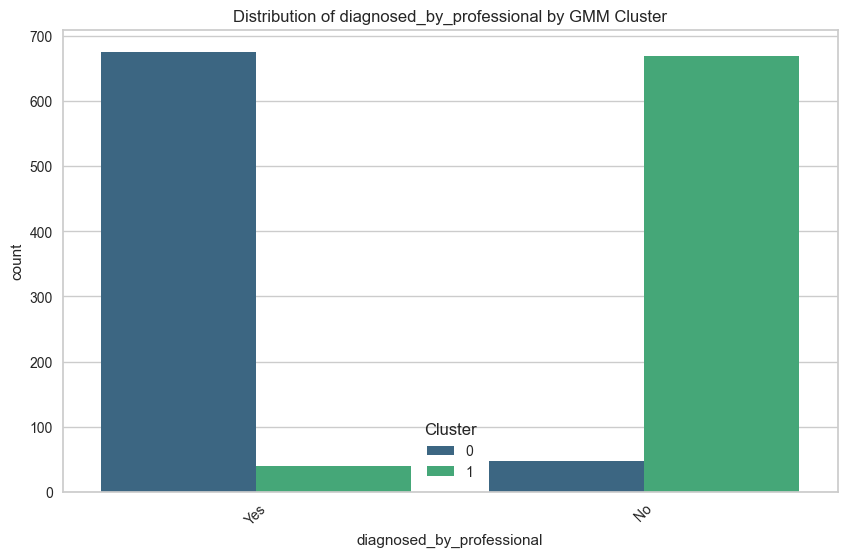

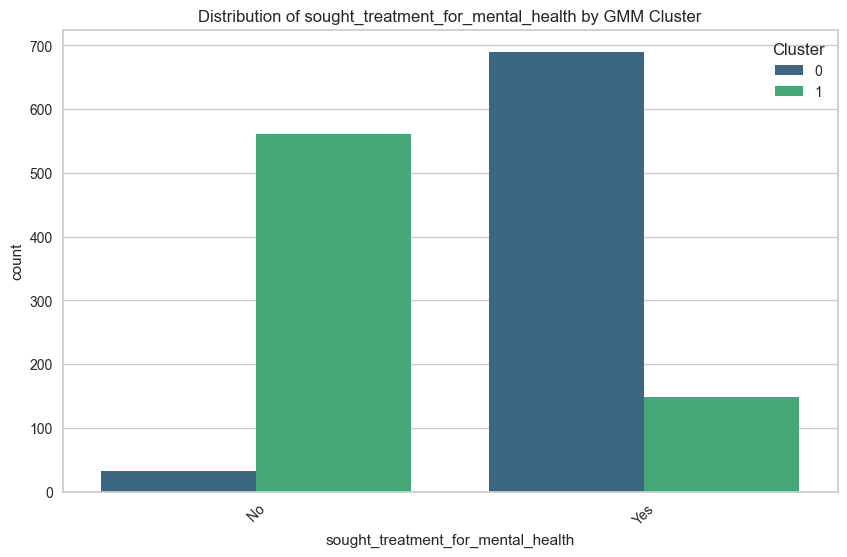

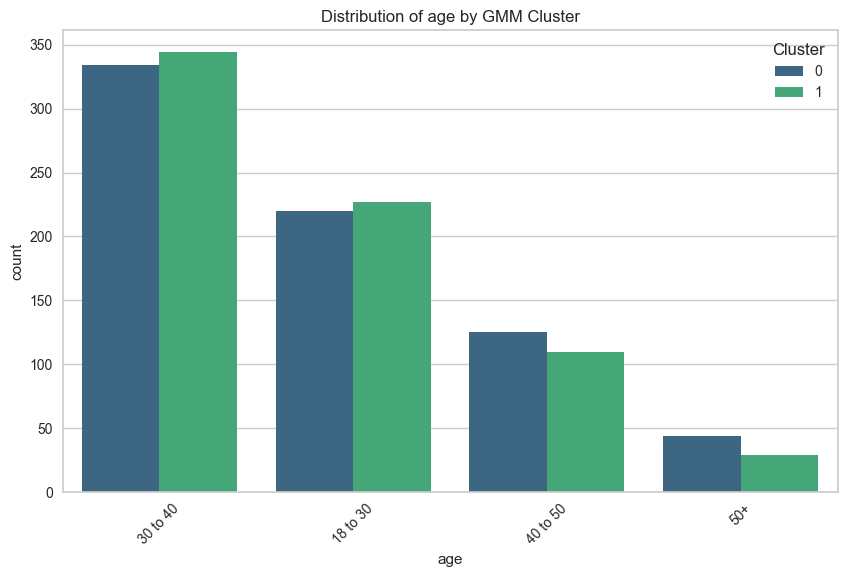

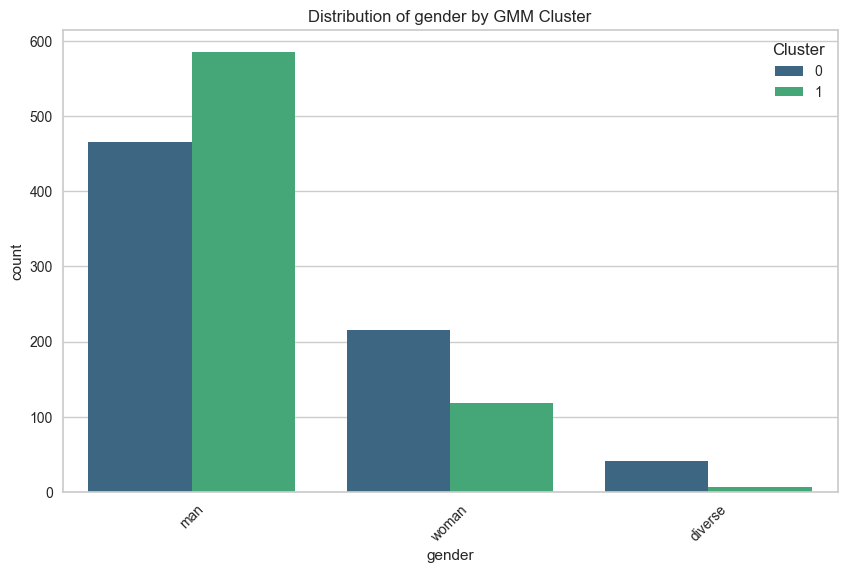

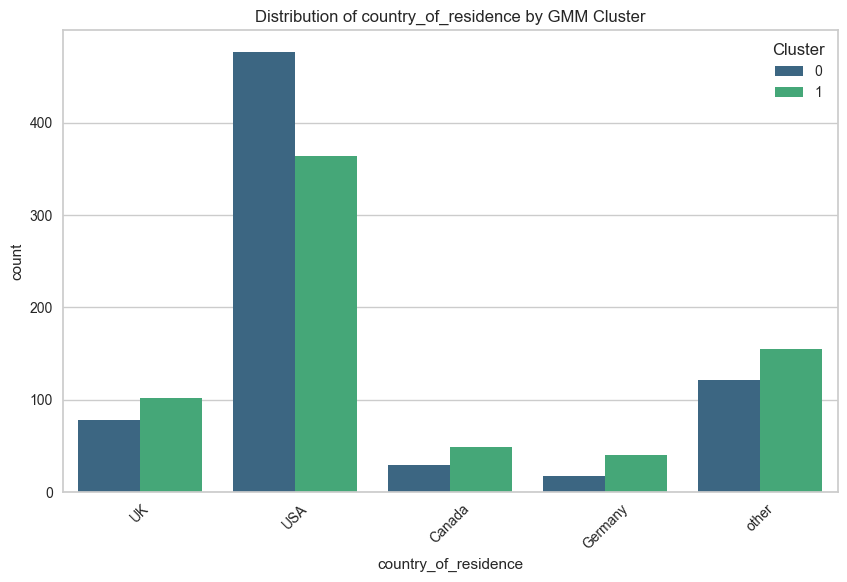

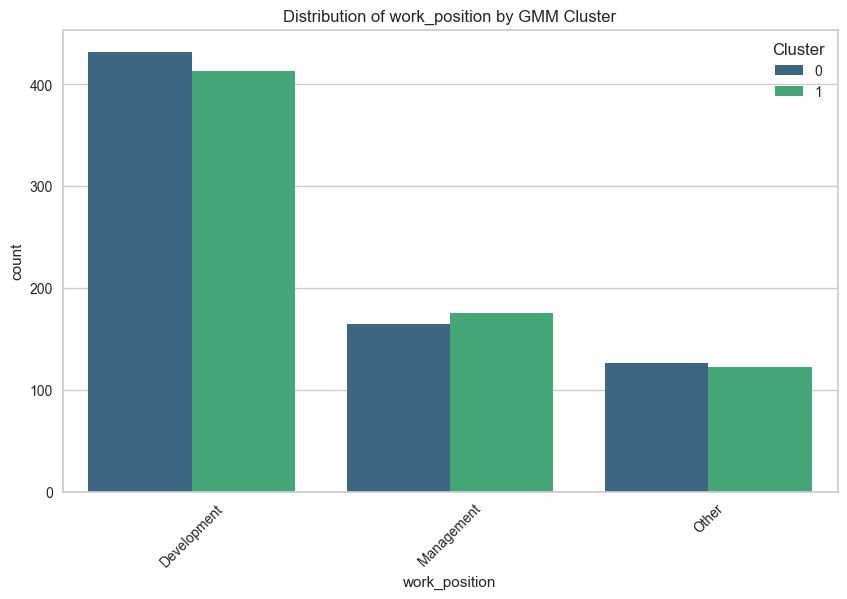

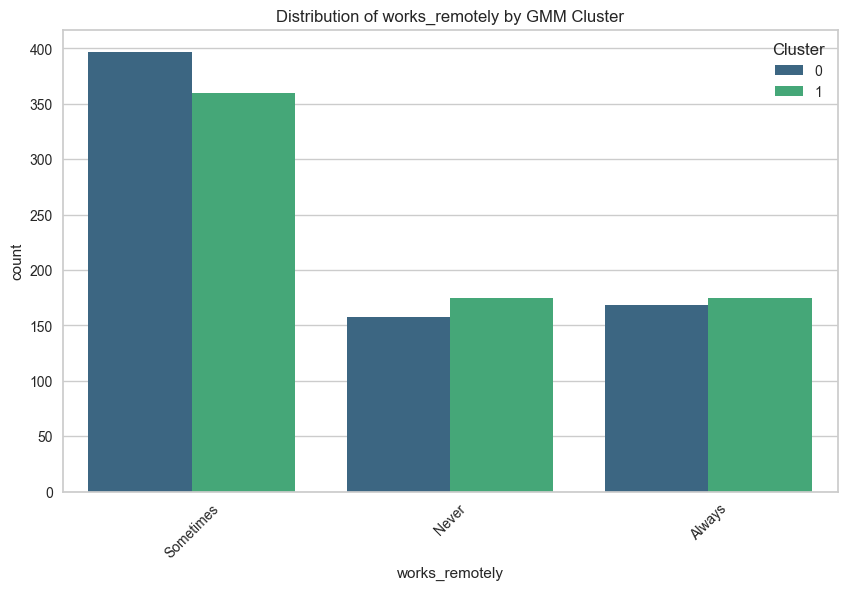

In [38]:
# Plotting bar charts for categorical feature distributions per cluster
data_with_cluster = data.copy()
data_with_cluster['Cluster'] = cluster_labels

# Step 4: Cluster Summaries (Similar to previous cell for K-Means clusters)
data_with_cluster['GMM_Cluster'] = gmm_labels

for feature in list(data.columns):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data_with_cluster, x=feature, hue='GMM_Cluster', palette="viridis")
    plt.title(f'Distribution of {feature} by GMM Cluster')
    plt.xticks(rotation=45)
    plt.legend(title="Cluster")
    plt.show()